In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import shutil

In [ ]:
from keras.layers import Flatten, Dense
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import binary_crossentropy

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import cv2
import glob

In [ ]:
ROOT_DIR = "/content/drive/{insert directory}"

In [ ]:
number_images = {}

In [ ]:
for dir in os.listdir(ROOT_DIR):
  number_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [ ]:
number_images

{'no': 98, 'yes': 155}

In [ ]:
if not os.path.exists("./dataset"):
  os.mkdir("./dataset")

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./dataset/" + dir)

    for img in os.listdir(os.path.join(ROOT_DIR, dir)):
      source = os.path.join(ROOT_DIR, dir, img)
      destination = os.path.join("./dataset", dir)
      shutil.copy(source, destination)
      # os.remove(source)

else:
  print("The folder dataset already exists")

In [ ]:
path_No_Tumor = f"./dataset/no/*"
path_Yes_Tumor = f"./dataset/yes/*"

In [ ]:
tumor = []
no_tumor = []

for file in glob.iglob(path_Yes_Tumor):
  img = cv2.imread(file)     
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing the color from BGR to RGB
  img = cv2.resize(img, (128, 128))
  tumor.append((img, 1)) 

for file in glob.iglob(path_No_Tumor):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 128))
  no_tumor.append((img, 0))

all_data = tumor + no_tumor

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

# Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

In [ ]:
# Normalize images

X_train = X_train / 255;
X_test = X_test / 255
X_val = X_val / 255;

In [ ]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


# Model Training - CNN Architecture

## Preparing training data

In [ ]:
base_model = MobileNet(input_shape=(128, 128, 3), include_top=False)

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)

In [ ]:
model = Model(base_model.input, X)

In [ ]:
model.compile(optimizer='rmsprop', loss=binary_crossentropy, metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_loss", verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=1)

callbacks = [model_checkpoint, early_stopping]

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks)

Epoch 1/50
5/6 [========================>.....] - ETA: 1s - loss: 2.3148 - accuracy: 0.6375
Epoch 1: val_loss improved from inf to 0.78955, saving model to bestmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 13s 1s/step - loss: 2.3006 - accuracy: 0.6398 - val_loss: 0.7895 - val_accuracy: 0.7561
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.5025 - accuracy: 0.8125
Epoch 2: val_loss improved from 0.78955 to 0.48818, saving model to bestmodel.h5
6/6 [==============================] - 3s 523ms/step - loss: 0.4994 - accuracy: 0.8137 - val_loss: 0.4882 - val_accuracy: 0.9024
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 0.1069 - accuracy: 0.9563
Epoch 3: val_loss did not improve from 0.48818
6/6 [==============================] - 2s 404ms/step - loss: 0.1062 - accuracy: 0.9565 - val_loss: 0.6247 - val_accuracy: 0.8537
Epoch 4/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0708 - accuracy: 0.9750
Epoch 4: val_loss improved from 0.48818 to 0.47787, saving model to bestmodel.h5
6/6 [==============================] - 3s 476ms/step - loss: 0.0703 - accuracy: 0.9752 - val_loss: 0.4779 - val_accuracy: 0.8537
E

In [ ]:
model = load_model("/content/bestmodel.h5")

In [ ]:
evaluate = model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 102ms/step - loss: 0.2058 - accuracy: 0.8750


In [ ]:
evaluate

[0.2057870328426361, 0.875]

In [ ]:
print("Loss: ", evaluate[0])
print("Accuracy: ", evaluate[1] * 100)

Loss:  0.2057870328426361
Accuracy:  87.5


In [ ]:
model.save("brain_tumor.h5")

## Graphical Interpretation

In [ ]:
history

In [ ]:
h = history.history

h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

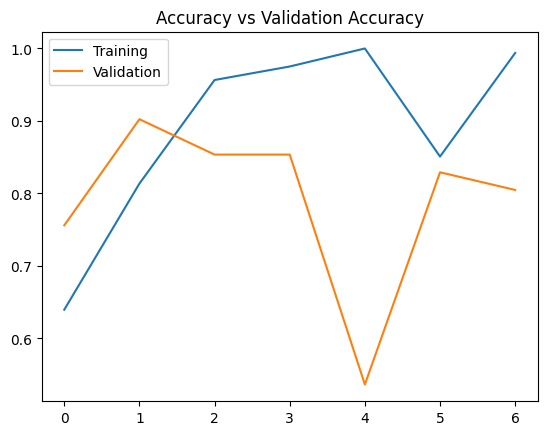

In [ ]:
plt.plot(h['accuracy'], label="Training")
plt.plot(h['val_accuracy'], label="Validation")
plt.title('Accuracy vs Validation Accuracy')
plt.legend(loc="upper left")
plt.show()

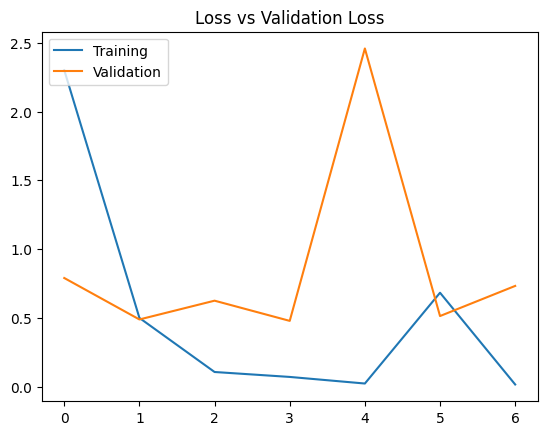

In [ ]:
plt.plot(h['loss'], label="Training")
plt.plot(h['val_loss'], label="Validation")
plt.legend(loc="upper left")
plt.title('Loss vs Validation Loss')
plt.show()

In [ ]:
y_prob = model.predict(X_test)

2/2 [==============================] - 1s 95ms/step


## Prediction and Evaluation

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
threshold = 0.5
binary_predictions = (y_prob > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

In [ ]:
y_test

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1])

Accuracy on Validation Set: 0.875 %


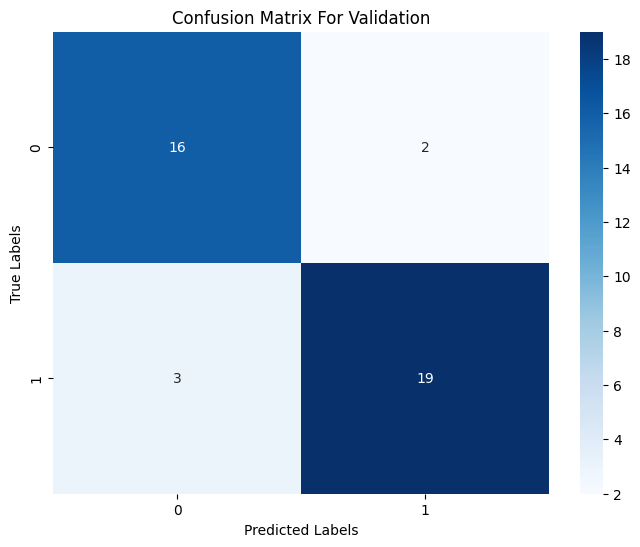

In [ ]:
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 68ms/step
CLASS:  [[1]]
The image represents a Tumor


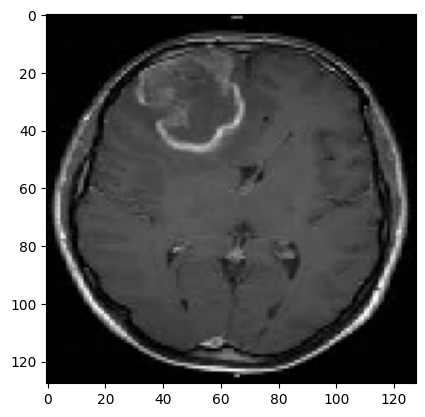

In [ ]:
file_path = "/content/dataset/yes/Y92.jpg"
img = load_img(file_path, target_size=(128, 128))

i = img_to_array(img) / 255
input_arr = np.array([i])
input_arr.shape

y_prob_img = model.predict(input_arr)
binary_pred = (y_prob_img > threshold).astype(int)

print("CLASS: ", binary_pred)


if binary_pred == 0:
  print("There is no Tumor")
else:
  print("The image represents a Tumor")

plt.imshow(input_arr[0])
plt.show()